# Rental Cycles EDA

In [194]:
#Imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt, dates as mdates
import seaborn as sns
import calendar
import xgboost as xgb

plt.style.use('ggplot')
pd.set_option('max_columns', 20)

In [91]:
df = pd.read_csv("JourneyDataExtractJan2019.csv")

## 1. Data understanding

In [92]:
df.shape

(617160, 9)

In [93]:
df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,83284852,660,8282,02/01/2019 17:47,94,"Bricklayers Arms, Borough",02/01/2019 17:36,197,"Stamford Street, South Bank"
1,83360769,180,4657,06/01/2019 18:14,94,"Bricklayers Arms, Borough",06/01/2019 18:11,269,"Empire Square, The Borough"
2,83280311,960,6306,02/01/2019 14:49,374,"Waterloo Station 1, Waterloo",02/01/2019 14:33,5,"Sedding Street, Sloane Square"
3,83323626,120,6217,04/01/2019 12:54,269,"Empire Square, The Borough",04/01/2019 12:52,94,"Bricklayers Arms, Borough"
4,83343322,120,848,05/01/2019 16:03,269,"Empire Square, The Borough",05/01/2019 16:01,94,"Bricklayers Arms, Borough"


In [94]:
df.columns

Index(['Rental Id', 'Duration', 'Bike Id', 'End Date', 'EndStation Id',
       'EndStation Name', 'Start Date', 'StartStation Id',
       'StartStation Name'],
      dtype='object')

In [95]:
df.dtypes

Rental Id             int64
Duration              int64
Bike Id               int64
End Date             object
EndStation Id         int64
EndStation Name      object
Start Date           object
StartStation Id       int64
StartStation Name    object
dtype: object

In [96]:
df.describe()

,Rental Id,Duration,Bike Id,EndStation Id,StartStation Id
count,6.171600e+05,617160.000000,617160.000000,617160.000000,617160.000000
mean,8.359058e+07,963.694828,8854.155592,364.007778,368.446069
std,1.850077e+05,3132.523813,4919.174859,243.556888,243.516094
min,8.327016e+07,60.000000,1.000000,1.000000,1.000000
25%,8.343035e+07,420.000000,4585.000000,154.000000,155.000000
50%,8.359042e+07,720.000000,8961.000000,329.000000,336.000000
75%,8.375065e+07,1140.000000,13447.000000,573.000000,574.000000
max,8.391144e+07,534180.000000,16382.000000,839.000000,839.000000


## 2. Data Cleaning

In [97]:
# Converting Start Date and End Date columns into date and time seperatly
df['Date'] = pd.to_datetime(df['Start Date'], dayfirst=True)
df['Leaving_Time'] = pd.to_datetime(df['Start Date']).dt.time
df['Arrival_Time'] = pd.to_datetime(df['End Date']).dt.time

In [98]:
df.tail()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,Date,Leaving_Time,Arrival_Time
617155,83423539,720,15849,09/01/2019 08:41,541,"Green Park Station, Mayfair",09/01/2019 08:29,208,"Mallory Street, Marylebone",2019-01-09 08:29:00,08:29:00,08:41:00
617156,83526613,120,8234,13/01/2019 15:14,201,"Dorset Square, Marylebone",13/01/2019 15:12,208,"Mallory Street, Marylebone",2019-01-13 15:12:00,15:12:00,15:14:00
617157,83533845,240,7783,14/01/2019 06:30,58,"New Inn Yard, Shoreditch",14/01/2019 06:26,536,"Queensbridge Road, Haggerston",2019-01-14 06:26:00,06:26:00,06:30:00
617158,83530579,720,6726,13/01/2019 18:26,202,"Leman Street, Aldgate",13/01/2019 18:14,536,"Queensbridge Road, Haggerston",2019-01-13 18:14:00,18:14:00,18:26:00
617159,83536834,120,8234,14/01/2019 08:05,114,"Park Road (Baker Street), The Regent's Park",14/01/2019 08:03,208,"Mallory Street, Marylebone",2019-01-14 08:03:00,08:03:00,08:05:00


In [99]:
# Setting Day of week as Catagorical column, helps with ordering
cat_type = pd.CategoricalDtype(list(calendar.day_name), ordered=True)
df['Day_Of_Week'] = pd.Categorical.from_codes(
    df['Date'].dt.day_of_week, dtype=cat_type
)

In [100]:
# Changing fields to String dtypes
df[['Rental Id', 'Bike Id', 'EndStation Id', 'StartStation Id', 'EndStation Name', 'StartStation Name']] = df[['Rental Id', 'Bike Id', 'EndStation Id', 'StartStation Id', 'EndStation Name', 'StartStation Name']].astype(str)

In [101]:
# Changing dates fields to datetime dtypes
df['Duration'] = df['Duration'].astype(float)

In [102]:
df.dtypes

Rental Id                    object
Duration                    float64
Bike Id                      object
End Date                     object
EndStation Id                object
EndStation Name              object
Start Date                   object
StartStation Id              object
StartStation Name            object
Date                 datetime64[ns]
Leaving_Time                 object
Arrival_Time                 object
Day_Of_Week                category
dtype: object

In [103]:
# Converting to minutes from seconds
df['Duration'] = df['Duration'] / 60.0

In [104]:
# Renaming columns
df = df.rename(columns={'Rental Id': 'Rental_Id',
                   'Bike Id': 'Bike_Id',
                   "End Date": "End_Date",
                   "EndStation Id": "EndStation_Id",
                   "EndStation Name": "EndStation_Name",
                   "Start Date": "Start_Date",
                   "StartStation Id": "StartStation_Id",
                   "StartStation Name": "StartStation_Name",
                   "Duration": "Duration"})

In [105]:
# Reorder df - Removing Start_Date & End_date as redundant
df = df[['Rental_Id', 'Bike_Id', 'Date', 'Day_Of_Week', 'Duration', 'StartStation_Id', 'StartStation_Name', 'Leaving_Time',
         'EndStation_Id', 'EndStation_Name', 'Arrival_Time']].copy()

In [106]:
df.dtypes

Rental_Id                    object
Bike_Id                      object
Date                 datetime64[ns]
Day_Of_Week                category
Duration                    float64
StartStation_Id              object
StartStation_Name            object
Leaving_Time                 object
EndStation_Id                object
EndStation_Name              object
Arrival_Time                 object
dtype: object

In [107]:
df.head()

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00
1,83360769,4657,2019-01-06 18:11:00,Sunday,3.0,269,"Empire Square, The Borough",18:11:00,94,"Bricklayers Arms, Borough",18:14:00
2,83280311,6306,2019-01-02 14:33:00,Wednesday,16.0,5,"Sedding Street, Sloane Square",14:33:00,374,"Waterloo Station 1, Waterloo",14:49:00
3,83323626,6217,2019-01-04 12:52:00,Friday,2.0,94,"Bricklayers Arms, Borough",12:52:00,269,"Empire Square, The Borough",12:54:00
4,83343322,848,2019-01-05 16:01:00,Saturday,2.0,94,"Bricklayers Arms, Borough",16:01:00,269,"Empire Square, The Borough",16:03:00


In [108]:
# Checking for rental id duplicates
df.shape[0] - df["Rental_Id"].nunique()

0

In [109]:
# Checking for Bike id duplicates
df.shape[0] - df["Bike_Id"].value_counts().sum()

0

In [110]:
# Checking for start station duplicates
df.shape[0] - df["StartStation_Id"].value_counts().sum()

0

In [111]:
# Checking for end station duplicates
df.shape[0] - df["EndStation_Id"].value_counts().sum()

0

In [112]:
# Checking Start and end ids for locations stay the same
df.query("StartStation_Id == '197'").head(3)

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00
5100,83393967,2700,2019-01-08 08:13:00,Tuesday,15.0,197,"Stamford Street, South Bank",08:13:00,54,"Golden Lane, Barbican",08:28:00
5101,83396070,8119,2019-01-08 08:39:00,Tuesday,11.0,197,"Stamford Street, South Bank",08:39:00,732,"Duke Street Hill, London Bridge",08:50:00


In [113]:
# Checking Start and end ids for locations stay the same
df.query("EndStation_Id == '197'").head(3)

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
1488,83409027,8656,2019-01-08 17:28:00,Tuesday,13.0,3,"Christopher Street, Liverpool Street",17:28:00,197,"Stamford Street, South Bank",17:41:00
2425,83382148,4276,2019-01-07 17:48:00,Monday,11.0,127,"Wood Street, Guildhall",17:48:00,197,"Stamford Street, South Bank",17:59:00
2671,83307202,8454,2019-01-03 17:50:00,Thursday,10.0,127,"Wood Street, Guildhall",17:50:00,197,"Stamford Street, South Bank",18:00:00


In [114]:
# Checking for nulls
df.isna().sum()

Rental_Id            0
Bike_Id              0
Date                 0
Day_Of_Week          0
Duration             0
StartStation_Id      0
StartStation_Name    0
Leaving_Time         0
EndStation_Id        0
EndStation_Name      0
Arrival_Time         0
dtype: int64

In [115]:
# Checking for record duplicates
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
617155    False
617156    False
617157    False
617158    False
617159    False
Length: 617160, dtype: bool

In [116]:
# Checking StartStation for mismatches
df[["StartStation_Name", "StartStation_Id"]].duplicated().value_counts()

True     616372
False       788
dtype: int64

In [117]:
# Checking if Id is duplicated
df.loc[~df.duplicated(subset=["StartStation_Name", "StartStation_Id"])]\
    ["StartStation_Id"].nunique()

788

In [118]:
# Checking EndStation for mismatches
df[["EndStation_Name", "EndStation_Id"]].duplicated().value_counts()

True     616372
False       788
dtype: int64

In [119]:
# Checking if Id is duplicated
df.loc[~df.duplicated(subset=["EndStation_Name", "EndStation_Id"])]\
    ["EndStation_Name"].nunique()

788

788 columns related to both StartStations & EndStations. No key-value pair mismatches. As Count(EndStation) = Count(StartStation) we can assume same subset of locations for both.

In [120]:
df.query("Leaving_Time > Arrival_Time")

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
3166,83290530,15580,2019-01-02 23:59:00,Wednesday,11.0,213,"Wellington Arch, Hyde Park",23:59:00,396,"Shouldham Street, Marylebone",00:10:00
3529,83334140,5782,2019-01-04 23:45:00,Friday,47.0,66,"Holborn Circus, Holborn",23:45:00,162,"Southampton Place, Holborn",00:32:00
3874,83334136,5271,2019-01-04 23:44:00,Friday,17.0,55,"Finsbury Circus, Liverpool Street",23:44:00,820,"Victory Place, Walworth",00:01:00
4100,83290482,1815,2019-01-02 23:44:00,Wednesday,21.0,188,"Nutford Place, Marylebone",23:44:00,358,"High Holborn , Covent Garden",00:05:00
5714,83389634,15567,2019-01-07 23:52:00,Monday,13.0,37,"Penywern Road, Earl's Court",23:52:00,660,"West Kensington Station, West Kensington",00:05:00
...,...,...,...,...,...,...,...,...,...,...,...
612591,83499012,15389,2019-01-11 23:58:00,Friday,4.0,607,"Putney Bridge Station, Fulham",23:58:00,727,"Chesilton Road, Fulham",00:02:00
615109,83498978,11170,2019-01-11 23:53:00,Friday,30.0,393,"Snow Hill, Farringdon",23:53:00,829,"Wynne Road, Stockwell",00:23:00
615993,83498939,6601,2019-01-11 23:48:00,Friday,14.0,436,"Red Lion Street, Holborn",23:48:00,328,"New North Road 2, Hoxton",00:02:00
616283,83533249,15764,2019-01-13 23:58:00,Sunday,8.0,809,"Lincoln's Inn Fields, Holborn",23:58:00,4,"St. Chad's Street, King's Cross",00:06:00


Around 0.2% of journeys carry on until the next day. A very small percentage so it doesn't affect trends. 

## 3. Feature Understanding
(Univariate Analysis)

In [121]:
df.head()

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00
1,83360769,4657,2019-01-06 18:11:00,Sunday,3.0,269,"Empire Square, The Borough",18:11:00,94,"Bricklayers Arms, Borough",18:14:00
2,83280311,6306,2019-01-02 14:33:00,Wednesday,16.0,5,"Sedding Street, Sloane Square",14:33:00,374,"Waterloo Station 1, Waterloo",14:49:00
3,83323626,6217,2019-01-04 12:52:00,Friday,2.0,94,"Bricklayers Arms, Borough",12:52:00,269,"Empire Square, The Borough",12:54:00
4,83343322,848,2019-01-05 16:01:00,Saturday,2.0,94,"Bricklayers Arms, Borough",16:01:00,269,"Empire Square, The Borough",16:03:00


In [122]:
# A function to plot a feature against value_counts()
def plot_tickets(col, title, xlabel, ylabel):
    plt.figure(figsize=(10,5))
    count = df[col].value_counts()\
    .head(10)\
    .plot(kind='barh', title=title, xlabel=xlabel, ylabel=ylabel)
    plt.tight_layout()
    plt.xticks(rotation=45)
    return count

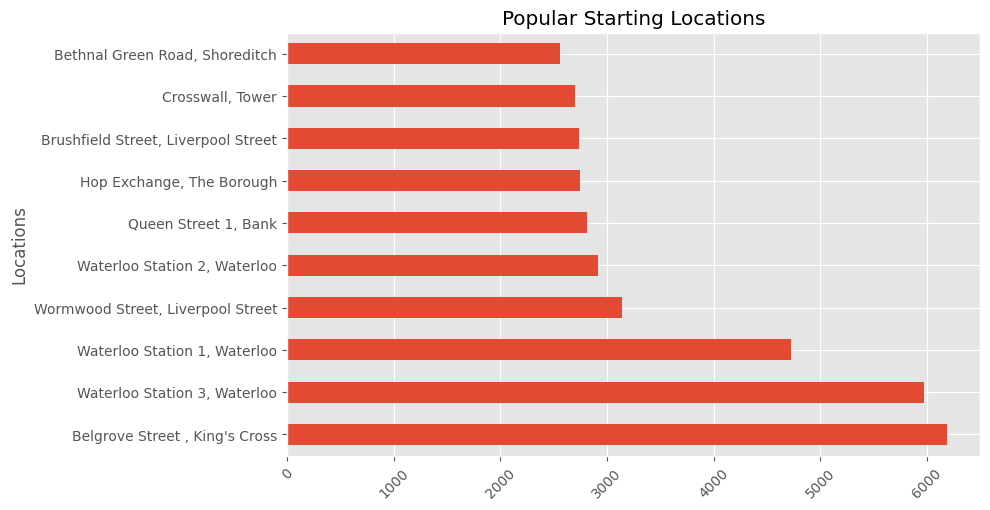

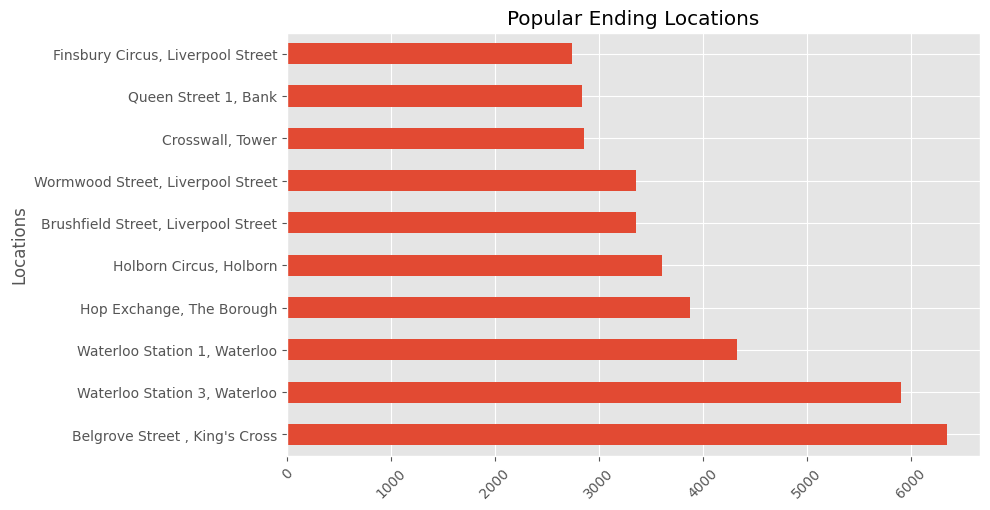

In [123]:
# Frequecy of locations
startStation = plot_tickets("StartStation_Name", "Popular Starting Locations", "Locations", "Frequency")
endStation = plot_tickets("EndStation_Name", "Popular Ending Locations", "Locations", "Frequency")

Between these two graphs we see the same stations, the numbers also seem to be relative to one another and follow a similar gradient. 

In [124]:
# Statistics related to Duration
df.describe()

,Duration
count,617160.00000
mean,16.06158
std,52.20873
min,1.00000
25%,7.00000
50%,12.00000
75%,19.00000
max,8903.00000


In [125]:
# Longest ride and shortest ride
print(f"Longest ride: {df['Duration'].max() / 60} Hours")
print(f"Shortest ride: {df['Duration'].min() * 60} Seconds")

Longest ride: 148.38333333333333 Hours
Shortest ride: 60.0 Seconds


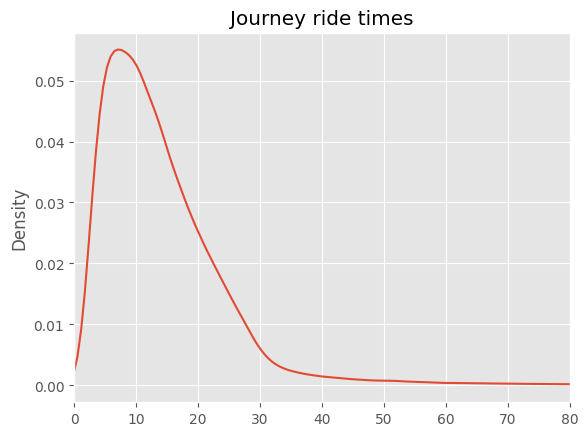

In [126]:
# Plotting count(Duration) to visulise most common ride durations
ax = df.query("Duration < 300")["Duration"].plot(kind='kde', xlim=[0,80], title="Journey ride times", xlabel="Time (minutes)")
plt.show()

This figure displays, relative to one another, the time users are willing to spend traveling on a rental bike. The spike indicates that roughly most people will be using bikes anywhere between ~1-20 minutes, the average being 16 minutes. As shown earlier the range of values that are recorded for journey times are quite extensive (140+ hrs), while these aren't too common compared to the actual data size I decided to limit the highest durations tp 300 minutes for this task. 

Perhaps low times (lowest possible is 1 due to rounding) and high times are indications of problems/ issues with the data collection or user experience. 

## 4. Data Relationships

Potential use cases
- Locations
    - Determine popular locations over a day to help predict where demand is at any point
    - Significance of locations. Mapping locations on a map, some end points may be near universities, office building etc. Perhaps feeds into consumer classification.
    - Identify busiest areas by how many bike ids visit it
    - Tracking the inflow and outflow of bikes to indicate areas which aren't balanced therefore will need manaul adjustments to bike stocks

- Journey
    - Mean ride duration. How far are people willing to ride? Recommends how far apart stations should be.
    - Low and high durations may indicate issues/problems?

- Types of people
    - Popular times of day to book bikes i.e rush hour, late night? 
    - What purpose could they have for booking? Traveling to work? Getting Home?
    - Spot patterns in the data to 'classify' consumers and understand what proportions form the base 

- Bikes
    - Track how often a bike is booked. Every 50 bookings or total duration of hours need servicing?
    - Measuring the frequency of repeating bike ids could give insight to whether there is a demand for more i.e. if only 3 bikes in an area but a demand for 10+ we would see the bike being hired all the time. Can also use to see the inverse of this.

In [127]:
df.head(3)

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00
1,83360769,4657,2019-01-06 18:11:00,Sunday,3.0,269,"Empire Square, The Borough",18:11:00,94,"Bricklayers Arms, Borough",18:14:00
2,83280311,6306,2019-01-02 14:33:00,Wednesday,16.0,5,"Sedding Street, Sloane Square",14:33:00,374,"Waterloo Station 1, Waterloo",14:49:00


In [128]:
df.dtypes

Rental_Id                    object
Bike_Id                      object
Date                 datetime64[ns]
Day_Of_Week                category
Duration                    float64
StartStation_Id              object
StartStation_Name            object
Leaving_Time                 object
EndStation_Id                object
EndStation_Name              object
Arrival_Time                 object
dtype: object

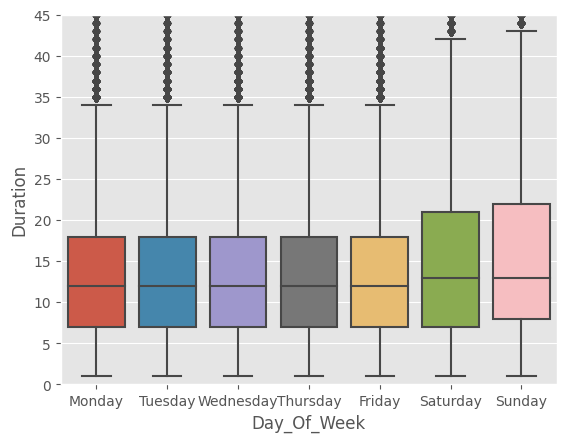

In [129]:
# Mean Average travel time per day
ax = sns.boxplot(x="Day_Of_Week", y=df["Duration"], data=df)
ax.set_ylim([0,45])

plt.show()

Similar to them figure above on avg durations total, this figure splits this across days of the week.

The box plot implies that on weekends people are more willing to use bikes to travel longer distances or perhaps that people are more willing to walk the shorter distances on a weekend as there is no 'deadline' to be anywhere i.e. offices, classes

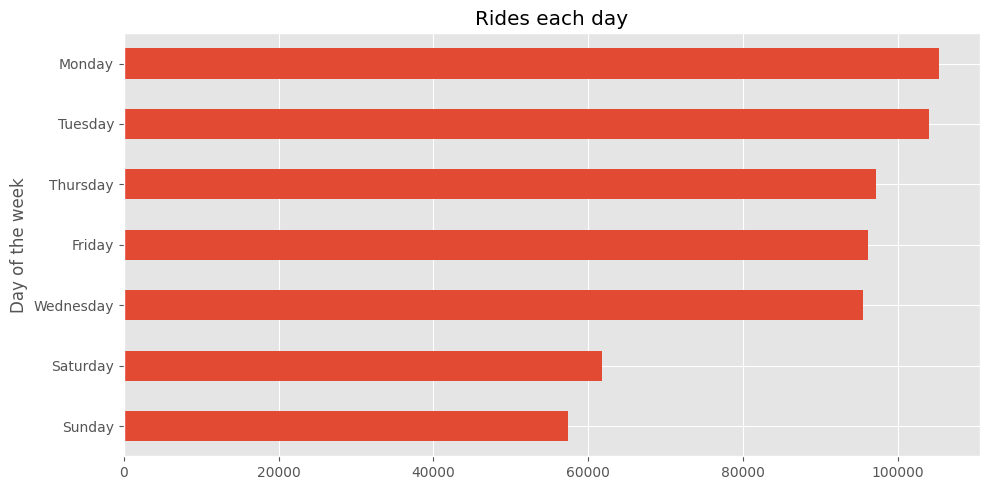

In [130]:
# Value count for rides taken each day of the week
df["Day_Of_Week"].value_counts(ascending=True).plot(
    kind="barh",figsize=(10, 5), title="Rides each day", ylabel="Number of rentals", xlabel="Day of the week"
)
plt.tight_layout()
plt.show()

Monday, Tuesday and Friday are the days for January 2019 which are the busiest for bike rentals.

### Modeling Bike rentals against time
For this model we are interested only in the leaving time and starting location as we want to determine where demand for bikes are. Typically the average journey will follow A -> B .... B -> A using the same method both ways. Using this logic we can see if whether the inflow and outflow of A in the morning is relative to A in the evening.

In [131]:
# Normalising the day of the dates as to plot easier
df['Time_Of_Day'] = pd.to_datetime('2000-01-01 ' +
                                   df['Date'].dt.time.astype(str))

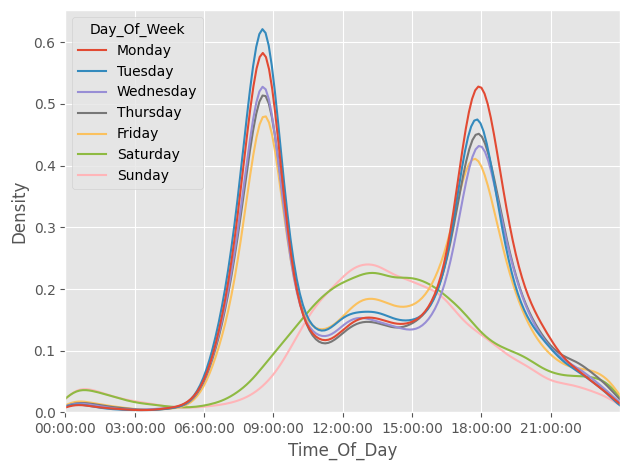

In [132]:
# Model demostrating the times people travel each day
ax = sns.kdeplot(data=df, x='Time_Of_Day', hue='Day_Of_Week')
ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),
             pd.to_datetime('2000-01-01 23:59:59')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

3 clear groups with some overlapp
- First Spike  6:00 -> 9:30
- Middle hump 9:00 -> 18:00
- Second Spike 15:00 -> 21:00

The two spikes are postioned at typical times of a 8-5 worker. From the last graph we know that Monday, Tuesday and Friday are the busiest times of the week which we can is the case when looking at the top of the peaks. This would help support the claim that people using the bikes at these periods would be office workers/workers or at least a large proportion. Saturday and Sunday also are two lowest at these points which again supports my findings.

We see a slight increase (middle hump) around midday for all days of the week, but majorly for Saturday and Sunday. Considering this alongside ealier results about the length of durations this implies that the bike is used for more leisurly activities. While it is hard to pinpoint/ classify the consumer based on this, due to a similar trend increase during the week, where most office workers won't be using it, implies another consumer group using it for probably lesiurely activities. People who may have free time at this time of day and still have a license to drive would be people like students.

Another interesting trend we can infer from this is a slight increase of bike usage on late Friday nights. It's quite popular to have drinks or go out on a Friday evening, its safe to assume as we don't see this on other days of the week that this is the likely cause. As driving a rental bike (lime bikes) are illegal while under the influence of alcohol there may be cause for concern at these periods. 

### Against locations
Now using the most popular locations to see where they apply on the time graph earlier.

In [133]:
# Getting the most popular starting locations as list
popular_locations = df["StartStation_Name"].value_counts().index[:10]
popular_locations

Index(['Belgrove Street , King's Cross', 'Waterloo Station 3, Waterloo',
       'Waterloo Station 1, Waterloo', 'Wormwood Street, Liverpool Street',
       'Waterloo Station 2, Waterloo', 'Queen Street 1, Bank',
       'Hop Exchange, The Borough', 'Brushfield Street, Liverpool Street',
       'Crosswall, Tower', 'Bethnal Green Road, Shoreditch'],
      dtype='object')

In [134]:
# Copying values into new column
df["Top_N"] = df["StartStation_Name"]

In [135]:
# New column which captures if it is a 'top_n' locations or other
df.loc[~df['StartStation_Name'].isin(popular_locations), 'Top_N'] = 'Other'

In [136]:
# Checking
df.loc[df["Top_N"] == "Other"].head()

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time,Time_Of_Day,Top_N
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00,2000-01-01 17:36:00,Other
1,83360769,4657,2019-01-06 18:11:00,Sunday,3.0,269,"Empire Square, The Borough",18:11:00,94,"Bricklayers Arms, Borough",18:14:00,2000-01-01 18:11:00,Other
2,83280311,6306,2019-01-02 14:33:00,Wednesday,16.0,5,"Sedding Street, Sloane Square",14:33:00,374,"Waterloo Station 1, Waterloo",14:49:00,2000-01-01 14:33:00,Other
3,83323626,6217,2019-01-04 12:52:00,Friday,2.0,94,"Bricklayers Arms, Borough",12:52:00,269,"Empire Square, The Borough",12:54:00,2000-01-01 12:52:00,Other
4,83343322,848,2019-01-05 16:01:00,Saturday,2.0,94,"Bricklayers Arms, Borough",16:01:00,269,"Empire Square, The Borough",16:03:00,2000-01-01 16:01:00,Other


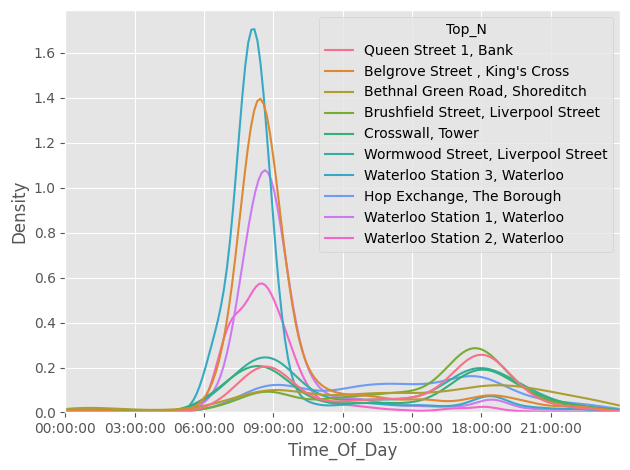

In [137]:
# Model popular locations leaving from over time
ax = sns.kdeplot(data=df.query("Top_N != 'Other'"), x='Time_Of_Day', hue='Top_N')
ax.set_xlim([pd.to_datetime('2000-01-01 00:00:00'),
             pd.to_datetime('2000-01-01 23:59:59')])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax.set_xlabel = ""
plt.tight_layout()
plt.show()

Removing the week days segmentation and using the top 10 locations instead we can see how each correlates to the pattern from the first intial graph. It also supports the claim e2e journeys as we can see a large spike for leaving locations in the moring rush hour but then at 5:00 a very small lump. If this was plotted on destination locations we would see the reverse of the graph. Stations like the Hop exchange perhaps follows the pattern on weekend usage whereas Waterloo station 3 is clearly used by workers.

## ML Model Predictions

In [138]:
df

,Rental_Id,Bike_Id,Date,Day_Of_Week,Duration,StartStation_Id,StartStation_Name,Leaving_Time,EndStation_Id,EndStation_Name,Arrival_Time,Time_Of_Day,Top_N
0,83284852,8282,2019-01-02 17:36:00,Wednesday,11.0,197,"Stamford Street, South Bank",17:36:00,94,"Bricklayers Arms, Borough",17:47:00,2000-01-01 17:36:00,Other
1,83360769,4657,2019-01-06 18:11:00,Sunday,3.0,269,"Empire Square, The Borough",18:11:00,94,"Bricklayers Arms, Borough",18:14:00,2000-01-01 18:11:00,Other
2,83280311,6306,2019-01-02 14:33:00,Wednesday,16.0,5,"Sedding Street, Sloane Square",14:33:00,374,"Waterloo Station 1, Waterloo",14:49:00,2000-01-01 14:33:00,Other
3,83323626,6217,2019-01-04 12:52:00,Friday,2.0,94,"Bricklayers Arms, Borough",12:52:00,269,"Empire Square, The Borough",12:54:00,2000-01-01 12:52:00,Other
4,83343322,848,2019-01-05 16:01:00,Saturday,2.0,94,"Bricklayers Arms, Borough",16:01:00,269,"Empire Square, The Borough",16:03:00,2000-01-01 16:01:00,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617155,83423539,15849,2019-01-09 08:29:00,Wednesday,12.0,208,"Mallory Street, Marylebone",08:29:00,541,"Green Park Station, Mayfair",08:41:00,2000-01-01 08:29:00,Other
617156,83526613,8234,2019-01-13 15:12:00,Sunday,2.0,208,"Mallory Street, Marylebone",15:12:00,201,"Dorset Square, Marylebone",15:14:00,2000-01-01 15:12:00,Other
617157,83533845,7783,2019-01-14 06:26:00,Monday,4.0,536,"Queensbridge Road, Haggerston",06:26:00,58,"New Inn Yard, Shoreditch",06:30:00,2000-01-01 06:26:00,Other
617158,83530579,6726,2019-01-13 18:14:00,Sunday,12.0,536,"Queensbridge Road, Haggerston",18:14:00,202,"Leman Street, Aldgate",18:26:00,2000-01-01 18:14:00,Other


In [139]:
df = df.set_index('Date')

In [140]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [141]:
df = create_features(df)
df.columns

Index(['Rental_Id', 'Bike_Id', 'Day_Of_Week', 'Duration', 'StartStation_Id',
       'StartStation_Name', 'Leaving_Time', 'EndStation_Id', 'EndStation_Name',
       'Arrival_Time', 'Time_Of_Day', 'Top_N', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear'],
      dtype='object')

In [155]:
df = df[['Duration', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear']]
df

,Duration,hour,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,
2019-01-02 17:36:00,11.0,17,2,1,1,2019,2
2019-01-06 18:11:00,3.0,18,6,1,1,2019,6
2019-01-02 14:33:00,16.0,14,2,1,1,2019,2
2019-01-04 12:52:00,2.0,12,4,1,1,2019,4
2019-01-05 16:01:00,2.0,16,5,1,1,2019,5
...,...,...,...,...,...,...,...
2019-01-09 08:29:00,12.0,8,2,1,1,2019,9
2019-01-13 15:12:00,2.0,15,6,1,1,2019,13
2019-01-14 06:26:00,4.0,6,0,1,1,2019,14


### Train / Test split

In [156]:
train = df.loc[df.index < '2019-01-25']
test = df.loc[df.index >= '2019-01-25']

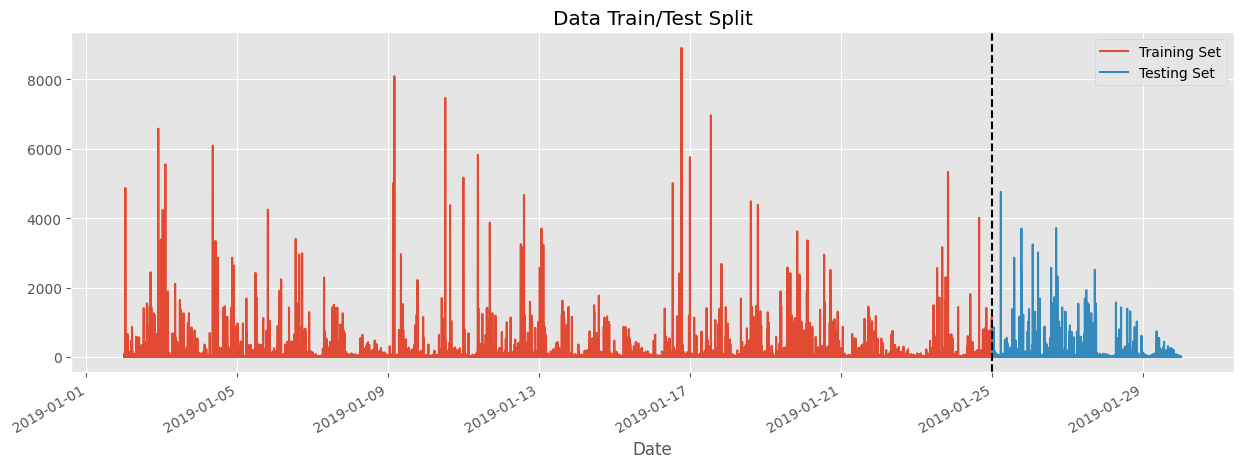

In [160]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Duration', label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, y='Duration', label='Testing Set')
ax.axvline('2019-01-25', color='black', ls='--')
plt.show()

<AxesSubplot:xlabel='Date'>

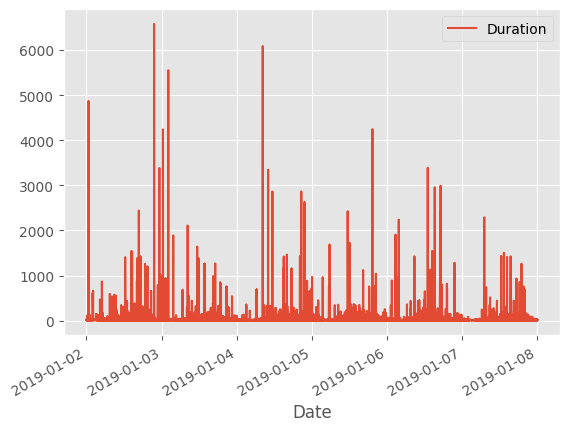

In [164]:
df.loc[(df.index > '2019-01-01') & (df.index < '2019-01-08')].plot(y='Duration')

Text(0.5, 1.0, 'Duration by hour')

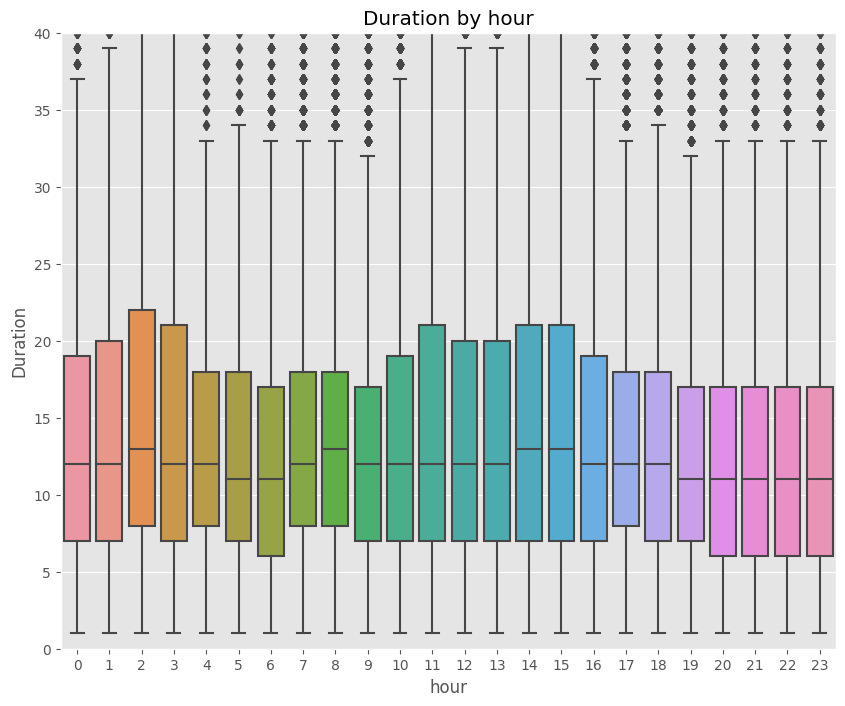

In [174]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='Duration').set(ylim=(0, 40))
ax.set_title('Duration by hour')

In [180]:
FEATURES = ['hour', 'dayofweek', 'dayofyear']
TARGET = 'Duration'

In [181]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [185]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:55.37718	validation_1-rmse:49.21273
[1]	validation_0-rmse:55.33019	validation_1-rmse:49.16250
[2]	validation_0-rmse:55.28410	validation_1-rmse:49.11324
[3]	validation_0-rmse:55.23889	validation_1-rmse:49.06490
[4]	validation_0-rmse:55.19454	validation_1-rmse:49.01750
[5]	validation_0-rmse:55.15104	validation_1-rmse:48.97098
[6]	validation_0-rmse:55.10836	validation_1-rmse:48.92537
[7]	validation_0-rmse:55.06651	validation_1-rmse:48.88061
[8]	validation_0-rmse:55.02546	validation_1-rmse:48.83672
[9]	validation_0-rmse:54.98519	validation_1-rmse:48.79350
[10]	validation_0-rmse:54.94570	validation_1-rmse:48.75128
[11]	validation_0-rmse:54.90696	validation_1-rmse:48.70969
[12]	validation_0-rmse:54.86896	validation_1-rmse:48.66908
[13]	validation_0-rmse:54.83169	validation_1-rmse:48.62907
[14]	validation_0-rmse:54.79514	validation_1-rmse:48.59000
[15]	validation_0-rmse:54.75929	validation_1-rmse:48.55152
[16]	validation_0-rmse:54.72413	validation_1-rmse:48.51395
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

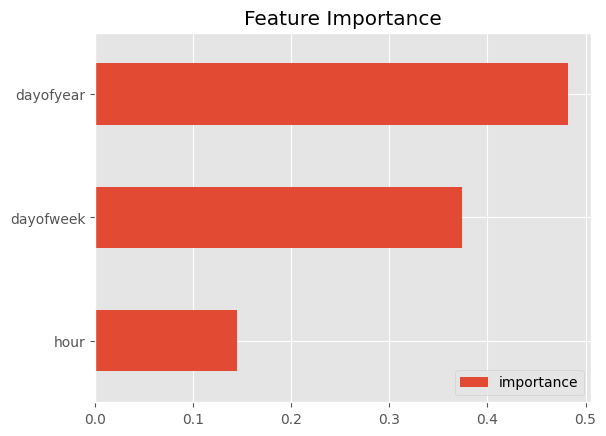

In [200]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast

In [203]:
test['Prediction'] = reg.predict(X_test)

/Users/liddingtonb/Documents/CVM/Repository/cvm-uk-picasso/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [208]:
df = df.merge(test[['Prediction']], how='left', left_index=True, right_index=True)

Text(0.5, 1.0, 'Forecasting Duration Times')

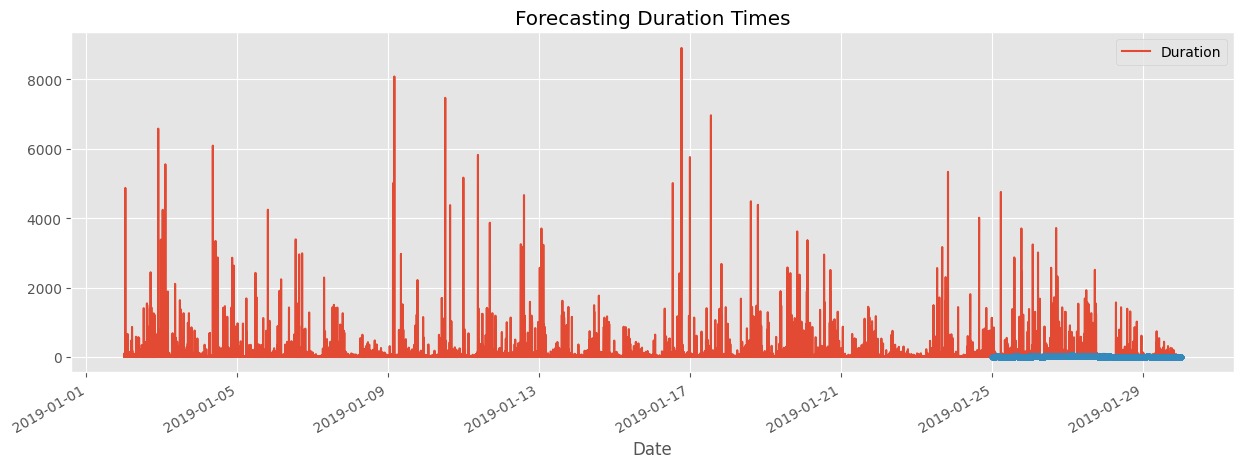

In [209]:
ax = df[['Duration']].plot(figsize=(15, 5))
df['Prediction'].plot(ax=ax, style='.')
ax.set_title('Forecasting Duration Times')

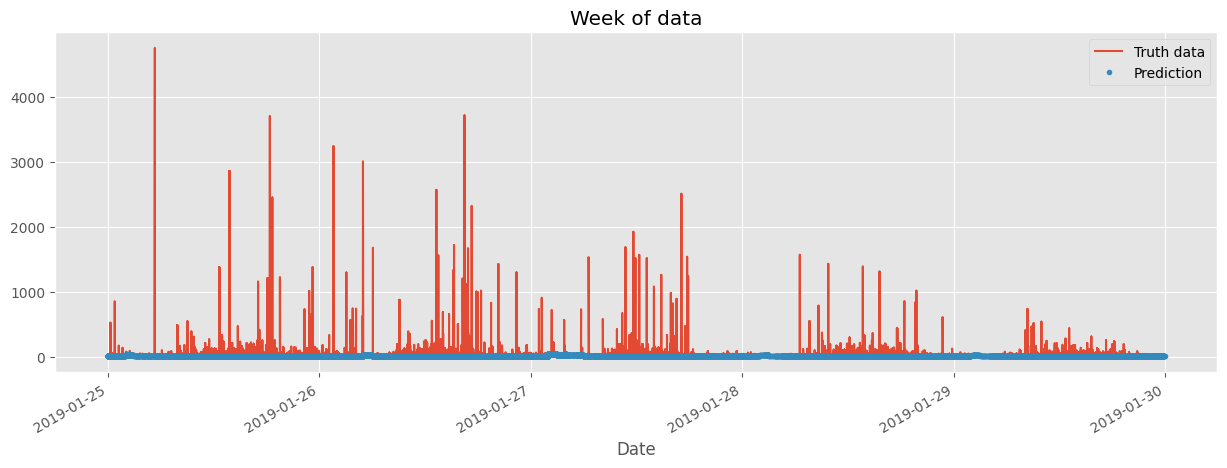

In [215]:
ax = df.loc[(df.index > '2019-01-25') & (df.index < '2019-01-31')]['Duration']\
    .plot(figsize=(15, 5), title="Week of data")
df.loc[(df.index > '2019-01-25') & (df.index < '2019-01-31')]['Prediction'].plot(style='.')
plt.legend(['Truth data', 'Prediction'])
plt.show()

In [217]:
df.tail()

,Duration,hour,dayofweek,quarter,month,year,dayofyear,Prediction
Date,,,,,,,,
2019-01-29 23:51:00,3.0,23,1,1,1,2019,29,13.164644
2019-01-29 23:51:00,3.0,23,1,1,1,2019,29,13.164644
2019-01-29 23:52:00,2.0,23,1,1,1,2019,29,13.164644
2019-01-29 23:55:00,2.0,23,1,1,1,2019,29,13.164644
2019-01-29 23:56:00,3.0,23,1,1,1,2019,29,13.164644
